<a href="https://colab.research.google.com/github/farsim-hossain/python-projects/blob/main/Regularization_Techniques_on_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preventing Overfitting With Regularizations

In [1]:
import tensorflow as tf 

from tensorflow.keras import layers 
from tensorflow.keras import regularizers

print(tf.__version__)

2.4.1


In [4]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

     |████████████████████████████████| 1.0MB 6.9MB/s 


In [5]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np 

import pathlib
import shutil
import tempfile 

In [27]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)



## The Higgs Dataset 
It contains 11 000 000 examples, each with 28 features, and a binary class label.

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 70s 0us/step


The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [8]:
FEATURES = 28

ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1),compression_type = "GZIP")


That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [9]:
# I guess this functions is just to make an organized view of rows
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label


TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new packed_ds.

The features are not perfectly normalized, but this is sufficient for this tutorial.# l

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


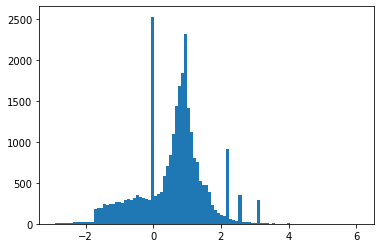

In [11]:
# Take a look at the first data point
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(),bins =101)

To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

In [12]:
N_VALIDATION =int(1e3)
N_TRAIN = int(1e4)

BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The Dataset.skip and Dataset.take methods make this easy.

At the same time, use the Dataset.cache method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [13]:
# Basically splitting the dataset into train and validation....these fancy 
#stuffs are used to handle large number of data
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds 

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These datasets return individual examples. Use the .batch method to create batches of an appropriate size for training. Before batching also remember to .shuffle and .repeat the training set.

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Start with a simple model using only layers.Dense as a baseline, then create larger versions, and compare them.

## Training Precedure 

Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time:


In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)


def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

  

## ITS ALL ABOUT EXPERIMENT AND NOODLING 

Lets visualize how the learning rate would drop

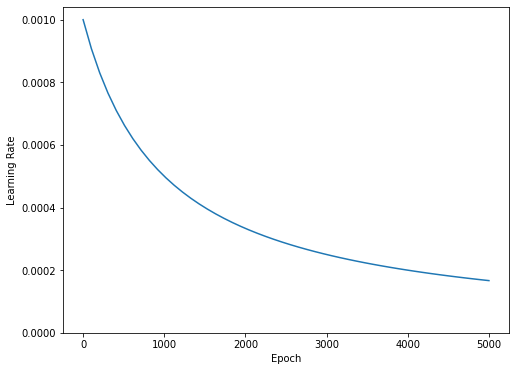

In [17]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize= (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')

_=plt.ylabel('Learning Rate')

## Recuding the logging for this large data

Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply prints a . for each epoch, and a full set of metrics every 100 epochs.

Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.

Use callbacks.TensorBoard to generate TensorBoard logs for the training.

In [25]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

## Model

In [21]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics = [
                             tf.keras.losses.BinaryCrossentropy(
                                 from_logits = True, name = 'binary_crossentropy'
                             ), 'accuracy'
                  ])
  model.summary()
  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose = 0
  )

  return history

So far we just designed the model with optimizers. There are more layers need to be fit in. We will try with a very small model now.

In [22]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(1)
])


In [23]:
# make an empty dictionary to sve models 

size_histories = {}


In [28]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4992,  binary_crossentropy:0.7271,  loss:0.7271,  val_accuracy:0.4640,  val_binary_crossentropy:0.7232,  val_loss:0.7232,  
....................................................................................................
Epoch: 100, accuracy:0.6052,  binary_crossentropy:0.6224,  loss:0.6224,  val_accuracy:0.5880,  val_binary_crossentropy:0.6223,  val_loss:0.6223,  
....................................................................................................
Epoch: 200, accuracy:0.64

# Lets visualize the model performance 

(0.5, 0.7)

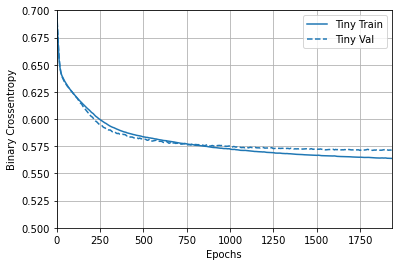

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Lets try with more layers 



In [30]:
small_model = tf.keras.Sequential([
                                   layers.Dense(16, activation='elu', input_shape = (FEATURES,)),
                                   layers.Dense(16, activation = 'elu'),
                                   layers.Dense(1)
                                   
])

In [31]:
size_histories ['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4849,  binary_crossentropy:0.7643,  loss:0.7643,  val_accuracy:0.4930,  val_binary_crossentropy:0.7013,  val_loss:0.7013,  
....................................................................................................
Epoch: 100, accuracy:0.6231,  binary_crossentropy:0.6122,  loss:0.6122,  val_accuracy:0.6140,  val_binary_crossentropy:0.6138,  val_loss:0.

## Medium Model 
Lets Try 3 hidden layers with 64 units each 

In [32]:
medium_model = tf.keras.Sequential([
                                    layers.Dense(64, activation = 'elu', input_shape = (FEATURES,)),
                                    layers.Dense(63, activation='elu'),
                                    layers.Dense(64, activation ='elu'),
                                    layers.Dense(1)
])

In [33]:
size_histories ['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 63)                4095      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4096      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,112
Trainable params: 10,112
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4978,  binary_crossentropy:0.6919,  loss:0.6919,  val_accuracy:0.4820,  val_binary_crossentropy:0.6733,  val_loss:0.6733,  
....................................................................................................
E

## Large Model 

In [34]:
large_model = tf.keras.Sequential([
                                   layers.Dense(512, activation='elu', input_shape =(FEATURES,)),
                                   layers.Dense(512, activation = 'elu'),
                                   layers.Dense(512, activation= 'elu'),
                                   layers.Dense(512, activation='elu'),
                                   layers.Dense(1)
])

In [35]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5063,  binary_crossentropy:0.7399,  loss:0.7399,  val_accuracy:0.5580,  val_binary_crossentr

## Plotting the models 

Text(0.5, 0, 'Epochs [log scale]')

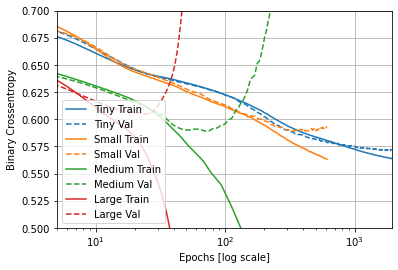

In [37]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [log scale]")

Clearly, the tiny model was better. **EARLYCALLBACK** stopped the training when it saw there was not significant improvement in the training